E=2908.9092961383294 at temperature = 300.0000000000001 time = 1727208851.7907865
E=3297.0938092246784 at temperature = 297.76159278385137 time = 1727208853.235588
pAccept = 0.8206303018660659
E=3162.6281366943085 at temperature = 295.53988712392027 time = 1727208854.8053174
E=3032.708318119814 at temperature = 293.334758403927 time = 1727208856.106292
pAccept = 0.8153825474262609
E=2865.6469357628152 at temperature = 291.1460829373984 time = 1727208857.4771895
E=2762.890140919184 at temperature = 288.97373796073 time = 1727208858.7351873
pAccept = 0.8167028678879001
E=3150.017372421294 at temperature = 286.8176016263007 time = 1727208860.0214045
E=2817.018978949004 at temperature = 284.6775529956378 time = 1727208861.2668993
pAccept = 0.8123214868270955
E=2565.5477295747246 at temperature = 282.55347203263443 time = 1727208862.5698261
E=3092.6848875781434 at temperature = 280.4452395968153 time = 1727208863.8336549
pAccept = 0.8085277913265876
E=3120.373509400723 at temperature = 278.

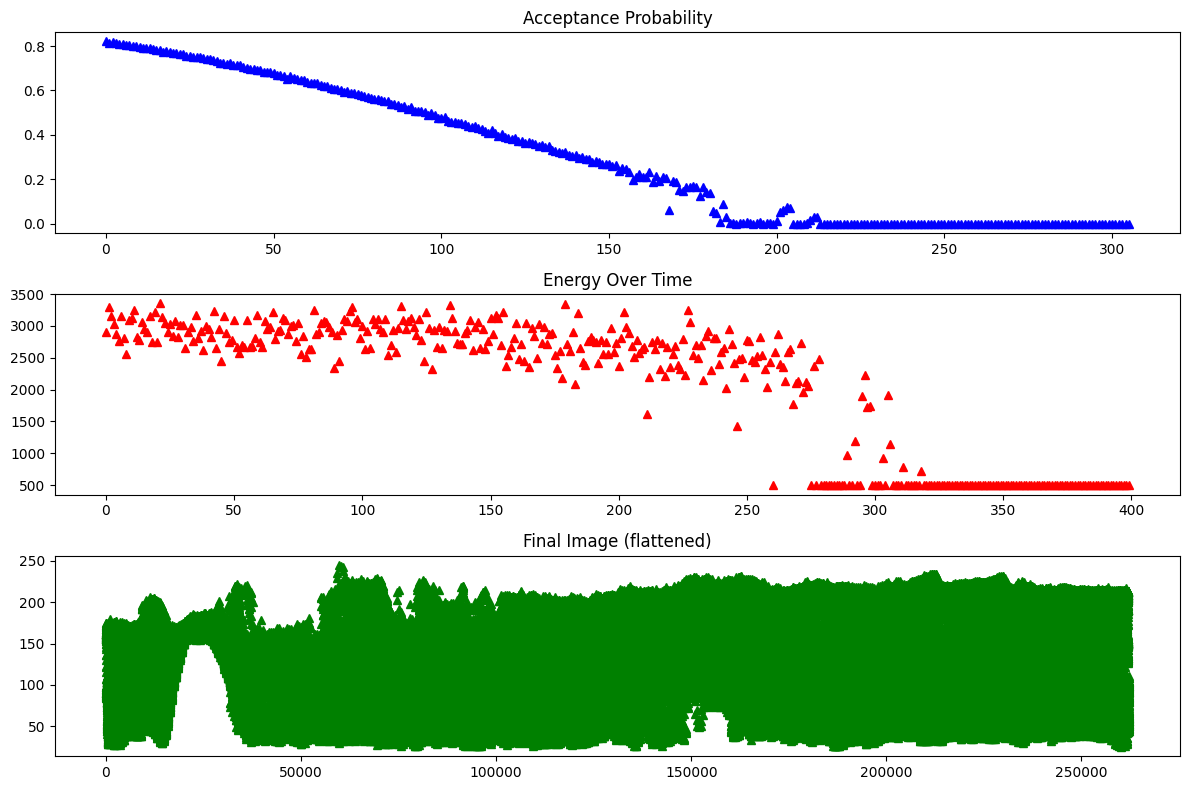

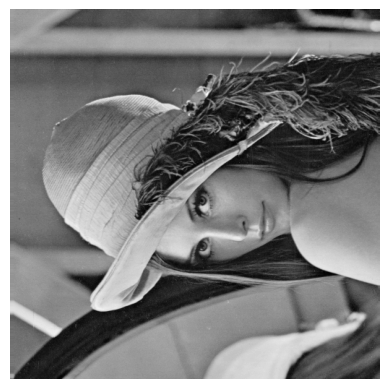

In [10]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time

# reading csv file from given path and flattening values of image column (pixel column) and storing it into image_data
def load_grayscale_image(file_path):
    df = pd.read_csv(file_path)
    image_data = df['image'].values.flatten()
    
    if image_data.size == 262144:  # Check if the size is correct (512x512) and if it isnt error handling is done
        image = image_data.reshape((512, 512)).astype(np.float64)
    else:
        raise ValueError("Unexpected image data size: {}".format(image_data.size))
    return image

class Energy:
    def __init__(self, data):
        self.image = data.image
        self.height = data.height
        self.width = data.width

    def getLeftRightEnergy(self, tile):
        i, j = tile
        x1 = 128 * i  # for 4x4 grid we have to adjust for 128
        x2 = 128 * (i + 1)
        y = 128 * (j + 1) - 1
        diff = self.image[x1:x2, y] - self.image[x1:x2, y + 1]
        return np.sqrt((diff**2).mean())

    def getUpDownEnergy(self, tile):
        i, j = tile
        y1 = 128 * j  # Adjusting to 128 for 4x4 grid
        y2 = 128 * (j + 1)
        x = 128 * (i + 1) - 1
        diff = self.image[x, y1:y2] - self.image[x + 1, y1:y2]
        return np.sqrt((diff**2).mean())

    def getEnergyAround(self, tile):
        i, j = tile
        e = np.zeros(4)
        if j > 0: e[0] = self.getLeftRightEnergy((i, j - 1))
        if j < self.width - 1: e[1] = self.getLeftRightEnergy((i, j))
        if i > 0: e[2] = self.getUpDownEnergy((i - 1, j))
        if i < self.height - 1: e[3] = self.getUpDownEnergy((i, j))
        return e.sum()

    def energy(self):
        energy = 0
        for i in range(self.height):
            for j in range(self.width):
                energy += self.getEnergyAround((i, j))
        return energy

class Data:
    def __init__(self, shuffledImage, height=4, width=4):
        self.image = np.copy(shuffledImage)
        self.height = height
        self.width = width
        self.tile_size = 128  # Each tile is 128x128 pixels

    def show(self):
        plt.imshow(self.image, cmap='gray')
        plt.axis('off')
        plt.show()

    def swap(self, i1, j1, i2, j2):
        t1 = np.copy(self.image[128 * i1: 128 * (i1 + 1), 128 * j1: 128 * (j1 + 1)])
        t2 = self.image[128 * i2: 128 * (i2 + 1), 128 * j2: 128 * (j2 + 1)]
        self.image[128 * i1: 128 * (i1 + 1), 128 * j1: 128 * (j1 + 1)] = t2
        self.image[128 * i2: 128 * (i2 + 1), 128 * j2: 128 * (j2 + 1)] = t1

class Logger:
    def __init__(self, data, loggingRate):
        self.data = data
        self.rate = loggingRate
        self.pAcceptArr = np.array([])
        self.energyArr = np.array([])
        self.pAcceptCurr = 0
        self.counter = 0

    def update(self, energy=0, pAccept=0):
        if energy > 0:
            self.energyArr = np.append(self.energyArr, energy)
        if pAccept > 0:
            self.pAcceptCurr += pAccept
            self.counter += 1
            if self.counter >= self.rate:
                print("pAccept = " + str(self.pAcceptCurr / self.rate))
                self.pAcceptArr = np.append(self.pAcceptArr, self.pAcceptCurr / self.rate)
                self.pAcceptCurr = 0
                self.counter = 0

    def logs(self):
        plt.figure(figsize=(12, 8))
        plt.subplot(3, 1, 1)
        plt.plot(self.pAcceptArr, 'b^')
        plt.title('Acceptance Probability')
        
        plt.subplot(3, 1, 2)
        plt.plot(self.energyArr, 'r^')
        plt.title('Energy Over Time')
        
        plt.subplot(3, 1, 3)
        plt.plot(self.data.image.flatten(), 'g^')
        plt.title('Final Image (flattened)')
        
        plt.tight_layout()
        plt.show()

class Proposal:
    def __init__(self, data, priorityRecomputeRate=1000, sigma=30):
        self.sigma = sigma
        self.priorityRecomputeRate = priorityRecomputeRate
        self.data = data
        self.counter = 0
        self.height = self.data.height
        self.width = self.data.width
        self.numTiles = self.height * self.width
        self.indices = [(i, j) for i in range(self.height) for j in range(self.width)]
        self.computeEnergies()

    def computeEnergies(self):
        self.sortedTiles = [(Energy(self.data).getEnergyAround((i, j)), (i, j)) for i, j in self.indices]
        self.sortedTiles.sort(reverse=True)

    def get(self):
        self.counter += 1
        if self.counter % self.priorityRecomputeRate == 0:
            self.counter = 0
            self.computeEnergies()
        i1, i2 = np.random.choice(range(self.numTiles), size=2, replace=False)
        _, t1 = self.sortedTiles[i1]
        _, t2 = self.sortedTiles[i2]
        return [t1, t2]

class Anneal:
    def __init__(self, data):
        self.data = data
        self.energy = Energy(data).energy()
        self.bestEnergy = self.energy
        self.logger = Logger(data, 10000)

    def step(self, temperature):
        t1, t2 = self.proposal.get()
        oldEnergy = Energy(self.data).getEnergyAround(t1) + Energy(self.data).getEnergyAround(t2)
        self.data.swap(t1[0], t1[1], t2[0], t2[1])
        newEnergy = Energy(self.data).getEnergyAround(t1) + Energy(self.data).getEnergyAround(t2)
        delta = newEnergy - oldEnergy
        pAccept = 1.0
        if delta > 0:
            pAccept = np.exp(-delta / temperature)
            self.logger.update(pAccept=pAccept)
        if np.random.rand() > pAccept:
            self.data.swap(t1[0], t1[1], t2[0], t2[1])  

    def do(self, start, end, numSteps, loggingRate=10000, proposalSigma=30):
        self.proposal = Proposal(self.data, proposalSigma)
        tempArray = np.logspace(np.log10(start), np.log10(end), int(numSteps)) 
        for i, temperature in enumerate(tempArray):
            self.step(temperature)
            if i % loggingRate == 0:
                self.energy = Energy(self.data).energy()
                print("E=" + str(self.energy) + " at temperature = " + str(temperature) + " time = " + str(time.time()))
                self.logger.update(energy=self.energy)



# Load the grayscale image from a text file converting .mat file to text 
image_file_path =r'C:\Users\Abhi Patel\Desktop\imgd.txt'  
original_image = load_grayscale_image(image_file_path)

# initialize data and annealing process
d = Data(original_image)
a = Anneal(d)

# setting high temprature will do more tile swaps
start_temp = 300  # Start with a higher temperature
end_temp = 15     # End with a lower temperature
num_steps = 4.0E+6 #iterations
proposal_sigma = 100  # Increase sigma to allow larger tile swaps

a.do(start=start_temp, end=end_temp, numSteps=num_steps, proposalSigma=proposal_sigma)

# log the results and display the final image
a.logger.logs()  
a.data.show()
